# Image Compression using AutoEncoders: a deep learning task

Time : 8h


Your name(s): Manuela ARDILA, Nicolas LASSO

Group: 2G1 - TP4

# Goal of this lab

* Get to know Deep Learning and PyTorch framework
* Learn how to compress images using AutoEncoders
* Understand the differences between JPEG compression and deep learning-based compression
* Know how to read and use code given by someone else


# Outline
* 0 - Introduction and documents reading
* 1 - Discovering a dataset
* 2 - Creating a Model
* 3 - Training the Model
* 4 - Testing the Model
* 5 - Reporting the findings

# Disclaimer

We will refer to :
- AutoEncoder as AE
- Multi Layer Perceptron as MLP

Please make sure that your environment has a GPU. For that, go to: 
* Execution
* Modifier le type d'execution
* Accelerateur matériel: GPU


We advice you to keep in an Excel Sheet or somewhere else the important values, for different parameters, that you will compute during this lab (accuracies, losses...)

# 0 - Introduction

We have seen JPEG compression, a general algorithm that can compress any image. Let's first see your understanding of the JPEG algorithm :
* What are the component in the encoding part of the algorithm ?
* What are the component in the decoding part of the algorithm ?
* Is the down-sampling phase of JPEG linear ? (i.e : in a y = ax+b form)
* Is it a lossless compression algorithm ?

## a- Your mission: AI for the Win

Hi there, we are a Big Company and we need your help as a data scientist. We have some images to compress. We tried the JPEG algorithm but we also want to try some modern methods based on deep learning (DL). 


In [110]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io
from tqdm import tqdm
import os
import time
import copy
import numpy as np
#from google.colab.patches import cv2_imshow
import cv2
import torchvision
import torchvision.transforms as transform




## b - Reading the documents 

**Very important: take 20-25 minutes to read the following documentation to understand the basic.**



### i - What is deep learning ?

Deep Learning is a branch of AI where you **teach a Model** a certain **task** using a **Dataset**. The model or a neural network is built by multiple consecutive **layers** of neuron-like units, remotely based on neurons in the human brain. Typically, many consecutive layers are used, that is why it is referred to as deep learning. In those layers, each neuron has several **parameters** (**weights**) that are updated during **training** by minimizing a **loss** (error) function, using **Stochastic Gradient Descent**. Besides the model parameters, to be found using a dataset, there are also **hyperparameters** that you have to tune by yourself, for example, how many layers used in your model, how many neurons per layer,.... The Model infers a prediction from an **input**. In fact, a Deep Neural Network can be seen as a complex function ${f}$ that maps the input data to a learned space from the Dataset. 

Note the bold words. These are the important things you need to understand about Deep Learning. 

### ii- Generalities on AutoEncoder

<img src = "https://blog.keras.io/img/ae/autoencoder_schema.jpg">

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) **data-specific**, 2) **lossy**, and 3) **learned** automatically from examples rather than engineered by a human. In almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1) Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. 

2) Autoencoders are lossy.

3) Autoencoders are learned automatically from data examples.

To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation. In fact, we can look at the model as a big function :

* Encoder : This part compresses the input image to a compressed version of it, where $f(x)= z$, where $x$ is the input image, and $z$ the compressed representation of it.
* Decoder : This part of the model decompresses the compressed representation $z$ to the decompressed image $\tilde{x}$, in other terms we have a function $g$ where, $\tilde{x} = g(z)$
* AutoEncoder : by stacking the Encoder and the Decoder, and as we want $\tilde{x} = x$ (a.k.a the reconstructed image as similar as the input image), we can rewrite the AE as $\tilde{x} = g(z) = g\circ f(x)=  x$ where $g= f^{-1}$



### iii - Layers

A Layer is an important part of a model. In fact, it is the key element of a DL model. A Layer is a structure that takes information from one layer to pass them to the next layer. In a DL network, each layer extracts some kinds of features. 

### iv -  Activation functions

An (non-linear) activation function decides the output of a neuron. It is the equivalent of the excitation threshold for which a neuron reacts or not.

**Hint**: ReLU is often used as activation function in hidden layers.

<img src = "https://miro.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png" height = 200>

# 1- Exploring the data

## Dataset

<img src="https://labelyourdata.com/img/article-illustrations/splitting_data.png" height=200>


When training  a DL model, we use a Dataset. The model uses the data to learn something for a task. We usually divide the data into Training, Validation, Test sets.
- Training set is used to train the Model (i.e., to find the parameters of Model).
- Validation set is used to watch the Model's training (to verify whether the training procedure goes well).
- Test set is used to evaluate the performance of the Model (in our case, to measure if the model compresses and decompresses well new images).

### ***Meme score: 6/10***

<img src="https://i.imgflip.com/653bu2.jpg" height=400>

**In our case of AE, we do not need the label of image. Our method is an unsupervised algorithm.**

### a - The first one : the training set

- What is the size of the training dataset?
- What are the elements available in one piece of data? (image, label)
- What is the shape of one piece of data?
- What is the type of one piece of data?
- Plot few elements of the dataset using Matplotlib.

The data is composed of 60 000 images of 28x28 pixels
47.04 mb
60000
torch.Size([28, 28])
tensor([5, 0, 4])


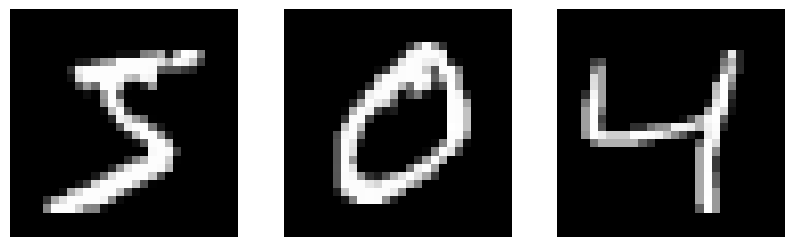

In [111]:
# TODO: Load MNIST Train Dataset from TorchVision

#how to use the MNIST function from torchvision to load the MNIST train dataset

dataset = MNIST('data', train=True, download=True, transform=transforms.ToTensor())

dataset

# TODO: What's the size of the Dataset ?
def get_size_in_bytes(tensor):
    return tensor.element_size() * tensor.nelement()
print("The data is composed of 60 000 images of 28x28 pixels")
print(get_size_in_bytes(dataset.data)/1000000, "mb")
# end TODO


# TODO: Retrieve one element of the Dataset ? What is the shape of one piece of Data ?

size_of_dataset =  len(dataset)
print(size_of_dataset)
data = dataset.data
print(data[0].shape) # Question : Why is there [0] ?
#We put the [0] because the dataset.data attribute is a list of images represented as tensor
# end TODO

# TODO: Plot the retrieved Data
#plot the first 3 elements on data



print(dataset.targets[0:3])
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(data[i], cmap='gray')
    plt.axis('off')
plt.show()



# end TODO






### b - The second one: the test dataset

As you can see in the above code, there's a "train" attribute of the MNIST class. When it is set to True, you are loading the training dataset. Therefore, in the following code, change it to false to load the test dataset.

In [112]:
# TODO : Load the test dataset. Inspire yourself from the mnist_train dataset loading

mnist_test = MNIST('data', train=False, download=True, transform=transforms.ToTensor())

# end TODO

Let's verify that the data in the test dataset are in the same style of the train Dataset :    
- Plot few data from the test dataset with its label.
- Are the data similar? Are the labels similar?

The size of the Dataset is:  10000
torch.Size([28, 28])
tensor([7, 2, 1])


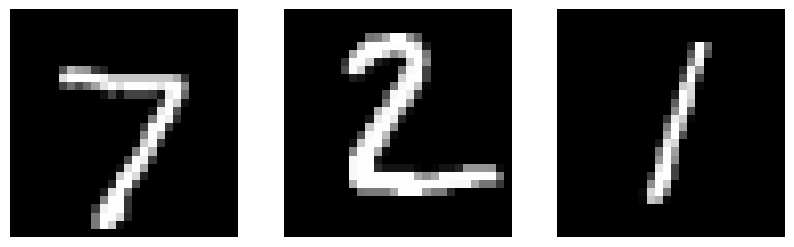

In [113]:
# TODO: What's the size of the Dataset ?
# TODO: Retrieve one element of the Dataset ? What is the shape of one piece of Data ? 
# TODO: Plot the retrieved Data

size_of_dataset = len(mnist_test)
test_data = mnist_test.data
#print the size of the dataset
print("The size of the Dataset is: ", size_of_dataset)
print(data[0].shape)

print(mnist_test.targets[0:3])

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(test_data[i], cmap='gray')
    plt.axis('off')
plt.show()




### c - The third one: creating the Validation dataset

Besides the training and testing sets, we would have a validation set. The validation set allows us to follow the training of model or in other words verify whether the training procedure goes well or not. 

In the next codes,
- What do 55000 and 5000 mean ?
- Determine the split value of the training set to create the validation dataset

In [114]:
# Questions : what does 55000 and 5000 mean ? Hint: look at the Dataset length and determine the split value
mnist_train, mnist_val = random_split(dataset, [55000, 5000])

#55000 and 5000 mean that we have 55000 images for the training set and 5000 images for the validation set
#this leave us with:
# 55000 Images for training
# 5000 Images for validation
# 10000 Images for testing
print(len(mnist_train))
print(len(mnist_val))



55000
5000


### d - Creating the Dataloaders

The dataset returns one element or item at a time. In DL, we prefer sending many items at the same time to the model. We form BATCH of Data using a DataLoader. Dataloader is an iterable over the dataset. It means that the Dataloader will form batches of Data for you and fetch them when you loop through it.

- Create a DataLoader for your Training, Validation and Test Dataset
- What is the drop_last attribute ?

More information on dataloader : https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [115]:
#The drop_last argument is used to drop the last batch if it is not complete

train_loader = DataLoader(mnist_train, batch_size=128,drop_last =True)
val_loader = DataLoader(mnist_val, batch_size=128,drop_last =True)
test_loader = DataLoader(mnist_test, batch_size=128,drop_last =True)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

print(train_loader.dataset[0][1])

429
39
78
5


- Is there enough data?
- Are they easily accessible?
- Are they correctly labeled?




# 2 - Creating and training the model: AutoEncoder

We saw what the data was and created our datasets. We need now to fullfil our mission and we need a model.

<img src="https://i.imgflip.com/640uob.jpg" height=300>

We are going to explore the path of AutoEncoder! Let's write some readable codes. Our code must be modulable and easy to read. We should try two types of AutoEncoders :    
- MLP Style
- Conv Style


Use PyTorch and Create Modulable and Stackable Models that inherits from nn.Module.




## a - MLP Style : Exploring the Neurons

<img src='https://www.researchgate.net/publication/344394387/figure/fig1/AS:974657746399232@1609387923440/Figure-Computational-Schematics-of-the-MLP-and-the-autoencoder.png'>

We will first try a MLP AE.




#### Creating a Model in PyTorch

Creating a model in PyTorch is simple. A PyTorch is an object that inherits from nn.Module. The pseudo-code is the following :     

```
class Model(nn.Module):
  def __init__(self,...):
    """"
    Define the model. You can put the input size as a parameter if needed..
    """"
    super().__init__() # to init the main class
    self.layers = ... # defining the model : could be Conv2d, Linear, RNN, LSTM


  def forward(self,x):
    """
    The input x is forwarded through the neural net. 
    """
    output = self.layers(x)
    return output

  # Other methods go down
```

More informations : https://pytorch.org/docs/stable/nn.html


### i - Correcting the Mistakes

First, we will try a really simple model :
* an Input Dense layer
* a latent space
* an Output Dense layer


We have received some codes from the other members of the Deep Learning Engineering Team. There are lots of mistakes... Let's correct them.

In [116]:
# TODO : Correct the Following Class. 
# Hint : Look at the input, output size, the activations, how the data is forwarded ...

class AutoEncoder_MLP(nn.Module):
  def __init__(self, input_size, compressed_space_size):
    """
    The model is an Input Layer, a Hidden Layer and an Output layer 
    """
    super().__init__() 
    # TODO : Init the class attributes thanks to the arguments of the init methods
    self.input_size = input_size
    self.output_size = compressed_space_size
    self.compressed_space_size = compressed_space_size
    # TODO : Correct the mistakes from the model
    self.input = nn.Sequential(nn.Linear(self.input_size, self.compressed_space_size),nn.ReLU())
    self.output = nn.Sequential(nn.Linear(self.output_size,self.input_size ),nn.Sigmoid())
    # end TODO: there are mistakes in all these 5 above lines

  def forward(self,x):
    """
    The input x is forwarded through the neural net. 
    """
    # TODO : Correct the mistakes
    x = x.view(-1, self.input_size)
    compressed_image = self.input(x)
    decompressed_image = self.output(compressed_image)
    return decompressed_image

In [125]:
# TODO : Create an Instance of the Model by calling the Class with the correct values

model = AutoEncoder_MLP(input_size = 784,compressed_space_size=16)

# TODO : Print the model.
print(model)



AutoEncoder_MLP(
  (input): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
  )
  (output): Sequential(
    (0): Linear(in_features=16, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


<img src="https://pbs.twimg.com/media/Ch8qBYwUkAIg9Tr.jpg" width="256" height="256">

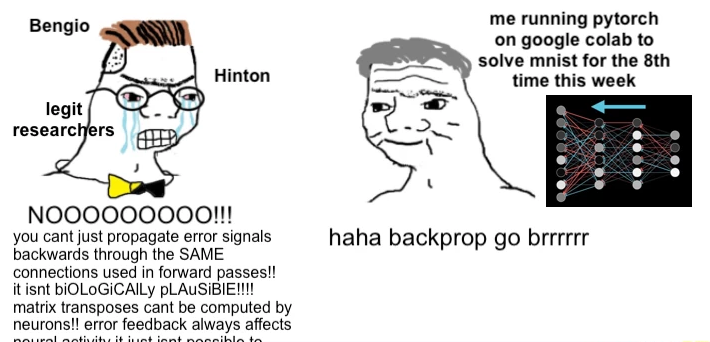




tensor([45, 36, 43, 15,  4, 42, 26])
['r', 'a', 'n', 'F', '4', 'h', 'Q']


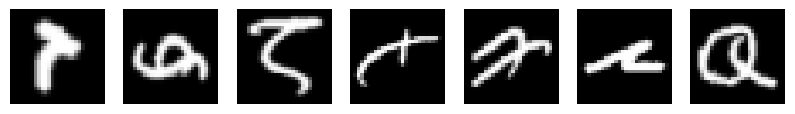

47


In [118]:

#How to download and create a EMNIST object
from torchvision.datasets import MNIST, CIFAR10, EMNIST
emnist_train = EMNIST('data', split='balanced', train=True, download=True, transform=transforms.ToTensor())

#plot the first 4 elements of emnist_train, but beofre print the labels of each element
print(emnist_train.targets[0:7])
classes = []
for item in emnist_train.targets[0:7]:
    classes.append(emnist_train.classes[item])

print(classes)


plt.figure(figsize=(10, 10))
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.imshow(emnist_train.data[i], cmap='gray')
    plt.axis('off')
plt.show()


#print the total of classes
print(len(emnist_train.classes))



## b - Training

We can train the model. We have a Model and a Dataset. We need few more things..



### i - Loss function

The loss function must tell us how far our predictions are from the true labels. 
This could be done by comparing the distributions of two input data, or by directly comparing the data using some distance metrics.

We are reconstructing an image from its compressed version and we want the reconstructed image as similar as possible to the original image. i.e $\tilde{x} = x$

<img src="https://i.imgflip.com/6946oe.jpg" height=400>



- How can you calculate the similarity between two vectors?
- What type(s) of loss function do you know that calculates the **distance** between two inputs?

More information: https://pytorch.org/docs/stable/nn.html#loss-functions

In [119]:
# TODO : Delete the uncorrect loss 

criterion = nn.MSELoss() #or nn.BCELoss() 
print(criterion(torch.tensor([1.0]), torch.tensor([1.0])))
print(criterion(torch.tensor([1.0]), torch.tensor([0.0])))




tensor(0.)
tensor(1.)


### ii - An Optimizer

<img src="https://i.imgflip.com/640sfs.jpg" height= 400>

We need to gradually update the weights of the model. In fact, we perform the **gradient descent** to recalculate the weights of each layer regarding the model's predictions. The optimizer will search for an Optimum. It needs a step to perform this research. This step is called the **learning rate**. The learning rate has an important effect on the learning phase (duration, convergence,...).
Think of the **gradient descent** as you trying to answer an exercise : the first time you won't understand, the second time you'll suceed more, and so on...

<img src=https://miro.medium.com/max/918/0*uIa_Dz3czXO5iWyI. height =300>

In this case, we will use Adam Optimizer (it is efficient). Don't hesitate to have a look at the other optimizers. 

More information: https://pytorch.org/docs/stable/optim.html

In [126]:
# TODO : define a small learning rate
learning_rate =  0.001
# TODO : load the Adam optimizer in the optimizer variable
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Waos


### iii - Training

Please use GPU to accelerate this phase.

Training a model consists of the following loop :
* Sending Data through the model to obtain Predictions
* Computing the Loss 
* Backwarding the Loss using Gradients 
* Logging the losses and accuracies (if exists) (Optional)

The number of epochs is a hyperparameter that defines the number of time the learning algorithm will work through the entire training dataset.



* Create your training and validation loop to train your model.

In [127]:
# Pre Defined and Useful variables
device = 'cuda' if torch.cuda.is_available() else 'cpu' # To send to the gpu
mini_batches_print = 10 # To print every 10 mini batches

# TODO : Send the model to the device using .to
net = model.to(device)

# TODO : Define your number of epochs

num_epochs = 20

loss_train , loss_val = [], []
for epoch in range(num_epochs) : 
    print("Epoch: ", epoch)
    running_loss_t,running_loss_v = 0.0, 0.0
    # TODO : Create your Training Loop
    for i, data in enumerate(train_loader, 0): 
        # TODO : load the data into two variables
        image, label = train_loader.dataset[i][0], train_loader.dataset[i][1]

        # TODO : reshape the input image using .view() so that it fits the input layers neuron numbers.
        # Don't forget the Batch Size, the 1rst dimension must always be the Batch Size
        image_reshaped, label = image.view(1, 28*28), label
        optimizer.zero_grad()

        # TODO : send the image to the model
        outputs = net(image_reshaped)

        # TODO/Questions : Do we need to reshape the input image ? If yes, reshape the image
        outputs = outputs.view(1, 28 * 28)
        #???????????????????

        # TODO : Compute the loss. Don't forget to send the image to the device
        loss = criterion(outputs, image_reshaped.to(device))

        loss.backward()
        optimizer.step()
        running_loss_t += loss.item()
        if i == mini_batches_print :
          running_loss_t= running_loss_t/mini_batches_print  
          print('training loss is :',running_loss_t)
          loss_train.append(running_loss_t)  

    # TODO : Create your Validation Loop
    with torch.no_grad():
      for i, data in enumerate(val_loader, 0):    
        # TODO : Do the same as the Train loop but delete everything related to weight update (optimizer, loss backwards ...)
        image, label = data[0].view(data[0].shape[0],-1).to(device), data[1]
        outputs = net(image)
        loss = criterion(outputs, image)
        optimizer.zero_grad() # Keep or not ?
        #loss.backward() # Keep or not ?

        running_loss_v += loss.item()
        if i == mini_batches_print :
            running_loss_v= running_loss_v/mini_batches_print 
            print('validation loss is :',running_loss_v)
            loss_val.append(running_loss_v)
            
      

Epoch:  0
training loss is : 0.25397231727838515
validation loss is : 0.07496270462870598
Epoch:  1
training loss is : 0.07135130055248737
validation loss is : 0.06758080013096332
Epoch:  2
training loss is : 0.06476291604340076
validation loss is : 0.06255476586520672
Epoch:  3
training loss is : 0.06003870628774166
validation loss is : 0.058399536460638043
Epoch:  4
training loss is : 0.055883361399173735
validation loss is : 0.05499039888381958
Epoch:  5
training loss is : 0.05232877023518086
validation loss is : 0.05201136693358421
Epoch:  6
training loss is : 0.04918883945792914
validation loss is : 0.049585844948887826
Epoch:  7
training loss is : 0.04670097604393959
validation loss is : 0.04772807583212853
Epoch:  8
training loss is : 0.044823555275797844
validation loss is : 0.0464117243885994
Epoch:  9
training loss is : 0.04358132760971785
validation loss is : 0.045458799228072166
Epoch:  10
training loss is : 0.042640458606183526
validation loss is : 0.04471914954483509
Epoc

### iv - Did it learn something ?

As you might see, we logged into two lists (train_loss, val_loss) losses computed during training. Let's plot them (do not forget to put titles and axis)
- How can you tell that the training is over?

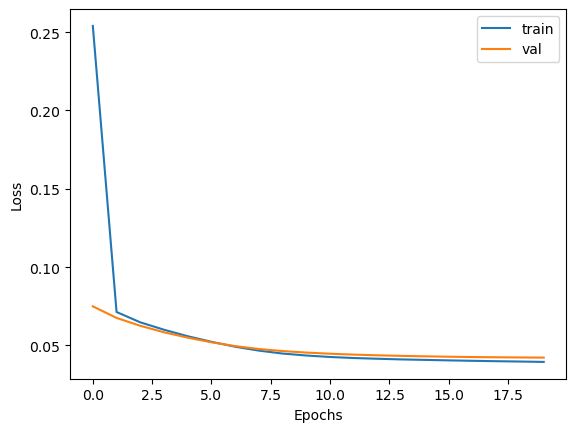

In [128]:
# TODO : plot the train and val loss on the same graph using matplotlib.pyplot.
# Always put legend on your graphs

plt.plot(loss_train, label='train')
plt.plot(loss_val, label='val')
#Name the axis of the graphs
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## c - Testing the compression

We already trained our model, let's test it on the testing set. We received an email from the senior Data Scientist :


---

 🔊 🔊 🔊 **Message from the Senior Data Scientist** 🔊 🔊 🔊

Hi, this is C. the Senior Data Scientist

I heard that you've trained your model. Let's test it.
Take the test dataloader, iterate through it and send the test data to the model. We need to check how similar to the original image the decompressed image is..
Do not forget to delete all gradient calculation, it takes time and space for nothing. 


---





* Why must we not compute the gradients for the testing step?



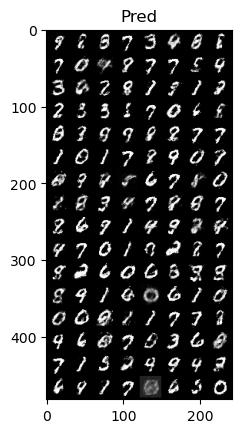

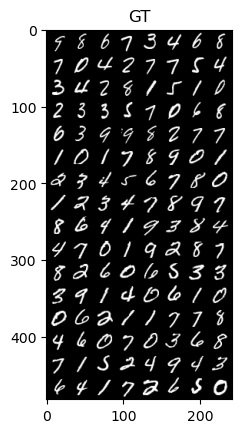

The difference between the Real Images and the Decompressed Images is:  tensor(0.0483)


In [ ]:
def imshow(img,name= 'GT'):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(name)
    plt.show()



newoutput = outputs
# TODO : form your testing loop. Is it different than the validation loop?
with torch.no_grad():
  losses = 0

  for i, data in enumerate(test_loader, 0):
    image, label = data[0].view(data[0].shape[0],-1).to(device), data[1]
    outputs = net(image)
    outputs = outputs.view([128, 1, 28, 28],-1)


    
  
  


#Print a MNIST chracter usin plt
#plt.imshow(image[0], cmap='gray')

# Plot the last batch
imshow(torchvision.utils.make_grid(outputs.detach().cpu()),'Pred')
imshow(torchvision.utils.make_grid(data[0]),'GT')


#plt.imshow(outputs[1])#.view(28,28), cmap='gray')

# TODO : Print the difference in decompression and write it somewhere
print('The difference between the Real Images and the Decompressed Images is: ', criterion(outputs, data[0]))



<img src="https://i.imgflip.com/64elyi.jpg" height=200>

Let's see the effect of the compression: 
* Change the latent_size to different values and compare the compression differences. 

For example, try 512, 128, 16, 1.



Compressed Size :  1
training loss is : 0.2643409699201584
training loss is : 0.07529310472309589
training loss is : 0.06917929351329803
training loss is : 0.06793886572122573
training loss is : 0.06748865246772766
training loss is : 0.06727727800607682
training loss is : 0.06716233044862747
training loss is : 0.0670935980975628
training loss is : 0.06704969443380833
training loss is : 0.06702026650309563


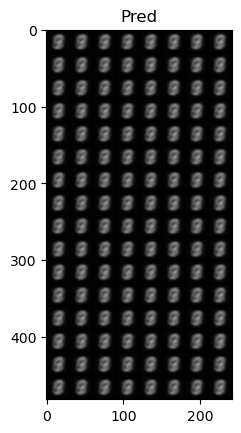

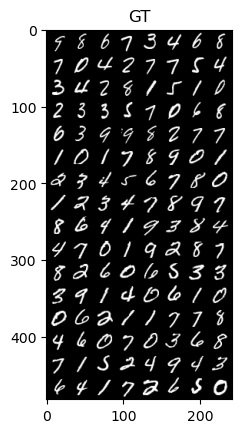

The decompression of the Encoded Test Dataset has an reconstruction error of:  tensor(0.0622)
Compressed Size :  128
training loss is : 0.14442026615142822
training loss is : 0.050913861393928526
training loss is : 0.039435083512216806
training loss is : 0.038892856892198326
training loss is : 0.041044295858591796
training loss is : 0.04058006936684251
training loss is : 0.03658868633210659
training loss is : 0.034981282381340864
training loss is : 0.03684433149173856
training loss is : 0.036325845122337344


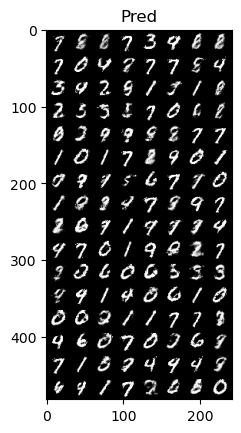

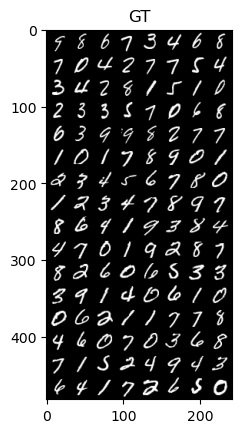

The decompression of the Encoded Test Dataset has an reconstruction error of:  tensor(0.0502)
Compressed Size :  512
training loss is : 0.13033790551126004
training loss is : 0.0545857060700655
training loss is : 0.041464170441031456
training loss is : 0.04401258789002895
training loss is : 0.045950470957905054
training loss is : 0.0377489467151463
training loss is : 0.03688483852893114
training loss is : 0.040507168136537076
training loss is : 0.04015838047489524
training loss is : 0.040143515542149545


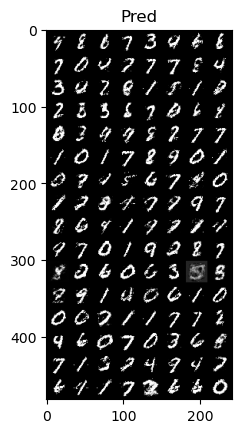

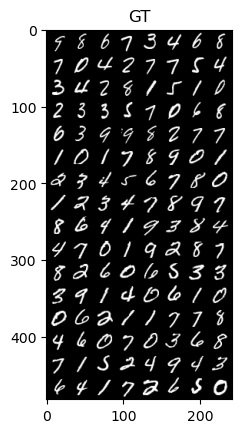

The decompression of the Encoded Test Dataset has an reconstruction error of:  tensor(0.0486)


In [144]:
  # TODO : Change your model, Test for differents size of Compressed Space Size. We advice you to try 1, 128, 512

loss_lists = []
for compressed_size in [1, 128, 512] :
    
    print('Compressed Size : ', compressed_size)
    model = AutoEncoder_MLP(28*28, compressed_size)

    # TODO : Train it. Can we copy paste previous things ?
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net = model.to(device)
    criterion = nn.MSELoss()
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    num_epochs = 10

    # TODO : Train it. Can we copy paste previous things ?
    for epoch in range(num_epochs) : 
        running_loss_t,running_loss_v = 0.0, 0.0
        # Train Loop
        for i, data in enumerate(train_loader, 0): 
            image, label = train_loader.dataset[i][0], train_loader.dataset[i][1]
            image_reshaped, label = image.view(1, 28*28), label
            optimizer.zero_grad()
            outputs = net(image_reshaped)
            outputs = outputs.view(1, 28 * 28)
            loss = criterion(outputs, image_reshaped.to(device))
            loss.backward()
            optimizer.step()
            running_loss_t += loss.item()
            if i == mini_batches_print :
              running_loss_t= running_loss_t/mini_batches_print  
              print('training loss is :',running_loss_t)
              loss_train.append(running_loss_t)

        # Validation Loop
        with torch.no_grad():
          for i, data in enumerate(val_loader, 0):  
            image, label = data[0].view(data[0].shape[0],-1).to(device), data[1]
            outputs = net(image)
            loss = criterion(outputs, image)
            optimizer.zero_grad()

    # TODO : Test the Trained Model. Can we copy paste previous stuff ?

    with torch.no_grad():
      running_loss = []
      for i, data in enumerate(test_loader, 0):  
        image, label = data[0].view(data[0].shape[0],-1).to(device), data[1]
        outputs = net(image)
        outputs = outputs.view([128, 1, 28, 28],-1)
    

    # Plot the last batch
    imshow(torchvision.utils.make_grid(outputs.detach().cpu()),'Pred')
    imshow(torchvision.utils.make_grid(data[0]),'GT')

    loss_lists.append(loss_train)

    # TODO : Print the reconstruction error over the test dataset

    print( 'The decompression of the Encoded Test Dataset has an reconstruction error of: ', criterion(outputs, data[0]))


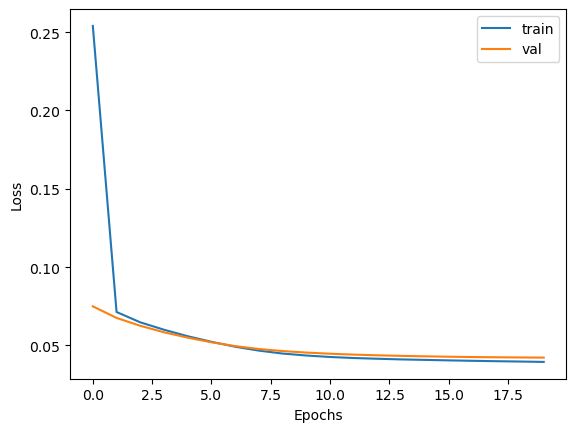

In [153]:
plt.plot(loss_train[0:20], label='train')
plt.plot(loss_val[0:20], label='val')
#Name the axis of the graphs
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()






## d - Testing on other type of data

We can say that the model works pretty well on the test data. Let's test it on other kind of images.

* Write the code to test the compression on **images** taken from the internet.

training loss is : 0.15331676825881005
training loss is : 0.05048221657052636
training loss is : 0.05280877519398928
training loss is : 0.048203982133418324
training loss is : 0.048581843823194505
training loss is : 0.045903872884809974
training loss is : 0.04511813968420029
training loss is : 0.04242938561365008
training loss is : 0.042485227342695
training loss is : 0.04285690374672413


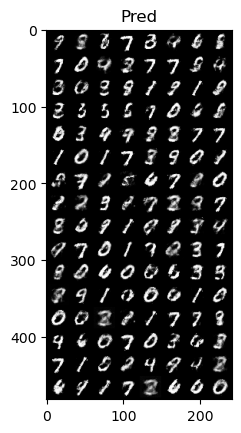

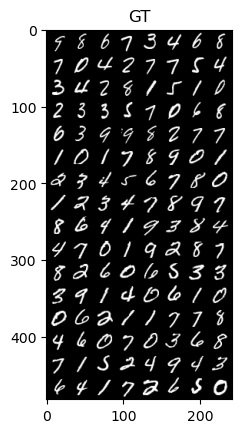

The decompression of the Encoded Test Dataset has an reconstruction error of:  tensor(0.0468)


In [165]:

model = AutoEncoder_MLP(28*28, 64)

# TODO : Train it. Can we copy paste previous things ?
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = model.to(device)
criterion = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10

# TODO : Train it. Can we copy paste previous things ?
for epoch in range(num_epochs) : 
    running_loss_t,running_loss_v = 0.0, 0.0
    # Train Loop
    for i, data in enumerate(train_loader, 0): 
        image, label = train_loader.dataset[i][0], train_loader.dataset[i][1]
        image_reshaped, label = image.view(1, 28*28), label
        optimizer.zero_grad()
        outputs = net(image_reshaped)
        outputs = outputs.view(1, 28 * 28)
        loss = criterion(outputs, image_reshaped.to(device))
        loss.backward()
        optimizer.step()
        running_loss_t += loss.item()
        if i == mini_batches_print :
            running_loss_t= running_loss_t/mini_batches_print  
            print('training loss is :',running_loss_t)
            loss_train.append(running_loss_t)

        # Validation Loop
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):  
            image, label = data[0].view(data[0].shape[0],-1).to(device), data[1]
            outputs = net(image)
            loss = criterion(outputs, image)
            optimizer.zero_grad()

    # TODO : Test the Trained Model. Can we copy paste previous stuff ?

    with torch.no_grad():
      running_loss = []
      for i, data in enumerate(test_loader, 0):  
        image, label = data[0].view(data[0].shape[0],-1).to(device), data[1]
        outputs = net(image)
        outputs = outputs.view([128, 1, 28, 28],-1)
    

    # Plot the last batch
imshow(torchvision.utils.make_grid(outputs.detach().cpu()),'Pred')
imshow(torchvision.utils.make_grid(data[0]),'GT')

loss_lists.append(loss_train)

# TODO : Print the reconstruction error over the test dataset

print( 'The decompression of the Encoded Test Dataset has an reconstruction error of: ', criterion(outputs, data[0]))


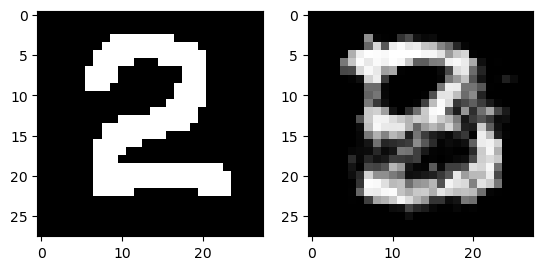

tensor(0.1115, grad_fn=<MseLossBackward0>)


In [166]:
# TODO : Test some images from the internet to see the compression effect 


image_filename = 'https://fastly.picsum.photos/id/106/512/512.jpg?hmac=PVd6wk__2-XQ1CrsNOLSMLCVfOegBJru-0bT3gcmY98'
image_test = 'https://github.com/MurphLaws/JPEGCompression/blob/main/data/testimage.png?raw=true'
image_test2 = 'https://github.com/MurphLaws/JPEGCompression/blob/main/data/testimage2.png?raw=true'
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Resize((28,28))])




inputImage = cv2.cvtColor(skimage.io.imread(image_test),cv2.COLOR_BGR2GRAY)



# # TODO : Transform the images and add a dimension for the batch size using unsqueeze
image = transform(inputImage).unsqueeze(0)

# # TODO : Send the model to the model and process the prediction. Don't forget 
# # the resizes
pred = model(image.view(1, 28 * 28).to(device))
# TODO : Plot dem results'. Don't forget to detach and send to the gpu the data
# using .detach().cpu()
fig,axarr = plt.subplots(1, 2)
axarr[0].imshow(image.view(28,28), cmap='gray')
axarr[1].imshow(pred.detach().cpu().view(28,28), cmap='gray')
plt.show()
print(criterion(pred.view(28,28),image.view(28,28)))


* What can you say ?

# 3- Write your report

* Sum up all your understanding on this subject in your report.

You should explain:
* The dataset you used for training,
* The tests you did,
* The models you tested,
* The results you had,
* The explanation of the results (why it works, why it doesn't),
* How can we compute the compression rate of the model? 
* Do we need to consider the model's size?

# 4 - Convolutional layer style : seeing a region

<img src="https://miro.medium.com/max/1838/1*LSYNW5m3TN7xRX61BZhoZA.png" height = 300>

---
 🔊 🔊 🔊 **Message from the senior data scientist** 🔊 🔊 🔊

Hello,

Good work! We need now to try another type of model.
Please consider Conv2d layers. 

Here you are some explanations: Convolutional Layers are filters that "scans" the input image in order to extract features. These filters extract features by looking at the region they're on.

I sent you some classes that you should use in your code. 

C.

<img src="https://i.imgflip.com/65b89l.jpg" height=300>

---



**Take 5 minutes to learn more about convolution with the following link:**

* https://ezyang.github.io/convolution-visualizer/

Questions:    
* What is the stride parameter?
* What is the padding parameter?
* What will change on the output when increasing the Kernel Size?

**Receptive field: are the pixels seen by filter kernel.**


## a - Model definition

Have a look at the model sent by the senior data scientist.

### i - Submodules

#### Conv Down

ConvDown is used to reduce the image size. A convolution on the input image is done using a kernel (the coefficients of kernel are weights to be found). In fact, it is used to extract interesting features of image. Our ConvDown Model will be composed of two layers:     
* Conv2d layer
* Non linearity (ReLU)

<img src="https://www.jeremyjordan.me/content/images/2017/07/no_padding_no_strides.gif">

In [ ]:
class ConvDown(nn.Module):
    """
    This class takes as input the channels and returns a feature map 
    for the given output channel. 
    It indeed applies ReLU to it
    ConvDown stacks a Conv2d layer with an ReLU Activation 

    """
    def __init__(self, input_channel, output_channel, kernel_size = 3):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.model = nn.Sequential(nn.Conv2d(self.input_channel, self. output_channel, kernel_size =self.kernel_size ),
                                    nn.ReLU())
                                    
    def forward(self,x):
        # TODO :  Send the data through the model and return the output
        output = self.model(x)
        return output

#### Conv Up

ConvUp is used to decompress the input image. In fact, it uses extracted features to reconstruct output feature map.

* Is it possible to increase output size map using Conv2d layers?

We can use also ConvTranpose2D layers, that use **transpose convolution** over an input image. These ConvTranspose layers learn to upsample the input images.

<img src="https://miro.medium.com/max/1400/1*HnxnJDq-IgsSS0q3Lut4xA.gif" height=200>

In [ ]:
class ConvUp(nn.Module):
    """
    ConvUp stacks a Conv2d layer with an Activation 
    If output is True : the Activation is Sigmoid
    If output is False : the Activation is ReLU
    """
    def __init__(self, input_channel, output_channel, kernel_size = 3 , output = True):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.output = output
        self.model = nn.Sequential(nn.ConvTranspose2d(self.input_channel, self. output_channel, kernel_size =self.kernel_size ),
                                    nn.ReLU()) if output is False else nn.Sequential(nn.ConvTranspose2d(self.input_channel, self. output_channel, kernel_size =self.kernel_size ),
                                    nn.Sigmoid())
        
    def forward(self,x):        
      # TODO :  Send the data through the model and return the output
      output = self.model(x)
      return output
    

### ii - Modules : the wrappers

#### Encoder

The encoder stacks multiple ConvDown to compress and extract features.

<img src="https://i.imgflip.com/65bqe0.jpg" height=300>

In [ ]:
class Encoder(nn.Module):
    """
    The encoder stacks multiple ConvDown to compress and extract features
    For the moment, we just keep one ConvDown layer

    """
    def __init__(self,input_channel, output_channel, kernel_size = 3):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.model = nn.Sequential( ConvDown(self.input_channel, self.output_channel,self.kernel_size))
                    
    def forward(self,x):
      # TODO :  Send the data through the model and return the output
      output = self.model(x)
      return output

#### Decoder

The decoder stacks multiple ConvUp to decompress and upsamples the input.

<img src="https://i.imgflip.com/65br5o.jpg" height=300>

In [ ]:
# TODO : Find the error in the initialization and correct it
class Decoder(nn.Module):
    """
    The Decoder stacks multiple ConvUp to upsample and reconstruct from the input
    another feature map
    For the moment, we just keep one ConvDown layer
    NEEDS TO BE CORRECTED

    """
    def __init__(self,input_channel, output_channel, kernel_size = 3, output = True):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.output = output
        self.model = nn.Sequential(ConvUp(self.input_channel,self.output_channel,self.kernel_size, output))
        
    def forward(self,x):
        # TODO :  Send the data through the model and return the output
        output = self.model(x)
        return output
    
model

AutoEncoder_Conv(
  (encoder): Sequential(
    (0): ConvDown(
      (model): Sequential(
        (0): Conv2d(1, 512, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
      )
    )
  )
  (decoder): Sequential(
    (0): ConvUp(
      (model): Sequential(
        (0): ConvTranspose2d(512, 1, kernel_size=(3, 3), stride=(1, 1))
        (1): Sigmoid()
      )
    )
  )
)

### iii - The Conv AutoEncoder: final model 

We stack encoder and decoder in order to form the autoencoder.


In [ ]:
# TODO : Stack the Encoder and the Decoder to Create the AE
# Be careful to respect the init attributes of the called class

class AutoEncoder_Conv(nn.Module):

    def __init__(self,input_size,latent_size, output= True):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.output = output
        self.model = nn.Sequential(Encoder(self.input_size, self.latent_size), 
                                    Decoder(self.latent_size, self.input_size, output = self.output))

    def forward(self,x):
        output = self.model(x)
        return  output


## b - Training and Testing

We can reuse the previously written code. However, we need to make some changes...


* What changes must we do?
* After making these changes, train your model for a latent size of 128.
* Test your model.

Latent Size :  16

Epoch number 0 :
training loss is : 0.2359602078795433
validation loss is : 0.13312928378582

Epoch number 1 :
training loss is : 0.13218574970960617
validation loss is : 0.06352512277662754

Epoch number 2 :
training loss is : 0.06297938339412212
validation loss is : 0.03021053075790405


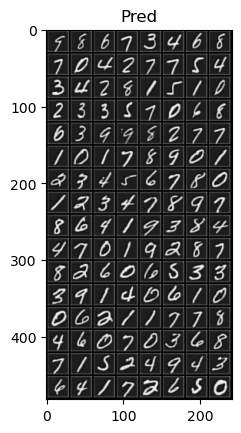

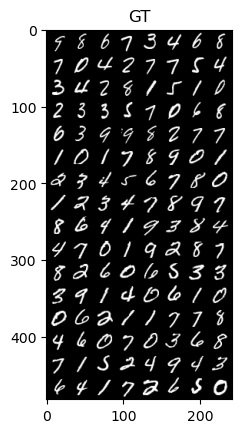

The decompression of the Encoded Test Dataset has an reconstruction error of:  0.02788764052093029
Latent Size :  32

Epoch number 0 :
training loss is : 0.21914969831705094
validation loss is : 0.07590248286724091

Epoch number 1 :
training loss is : 0.07500834986567498
validation loss is : 0.0332269312813878

Epoch number 2 :
training loss is : 0.03296082578599453
validation loss is : 0.018283294700086116


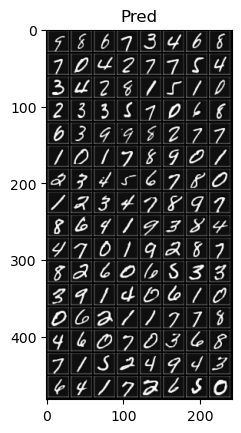

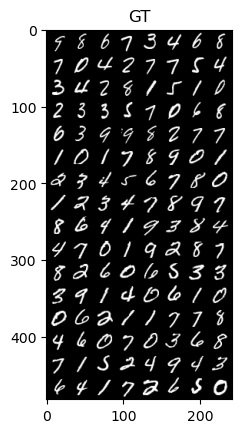

The decompression of the Encoded Test Dataset has an reconstruction error of:  0.01680019684135914
Latent Size :  128

Epoch number 0 :
training loss is : 0.25903532952070235
validation loss is : 0.020553725585341454

Epoch number 1 :
training loss is : 0.020287670753896238
validation loss is : 0.009128874819725751

Epoch number 2 :
training loss is : 0.009075297601521015
validation loss is : 0.005628177430480719


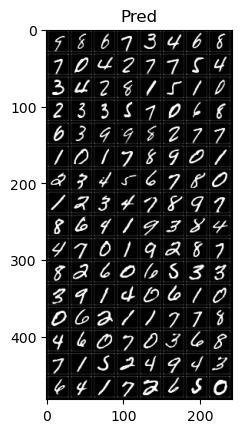

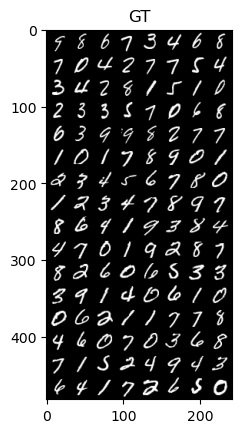

The decompression of the Encoded Test Dataset has an reconstruction error of:  0.005075889173895121


In [155]:
from torch.nn.modules.loss import MSELoss
    # TODO : Change your model 

for latent_size in [16,32,128]:
    
    print("Latent Size : ", latent_size)
    
    model = AutoEncoder_Conv(input_size = 1,latent_size =latent_size)

    # TODO : Reload your HyperParameters

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net = model.to(device)
    criterion = nn.MSELoss()
    learning_rate = 0.0001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    num_epochs = 3

    # TODO : Rewrite your Training and Validation Loop
    for epoch in range(num_epochs) : 
        running_loss_t,running_loss_v = 0.0, 0.0
        print("\nEpoch number", epoch,":")
        
        for i, data in enumerate(train_loader, 0):
          image = data[0].to(device)

          optimizer.zero_grad()

          outputs = net(image)
          outputs = outputs.view(image.shape)
          loss = criterion(image, outputs)

          loss.backward()
          optimizer.step()
          running_loss_t += loss.item()
          if i == mini_batches_print :
            running_loss_t= running_loss_t/mini_batches_print  
            print('training loss is :',running_loss_t)
            loss_train.append(running_loss_t)  



        with torch.no_grad():
          for i, data in enumerate(val_loader, 0):
            image = data[0].to(device)
            
            outputs = net(image)
            outputs = outputs.view(image.shape)
            loss = criterion( image , outputs )

            running_loss_v += loss.item()
            if i == mini_batches_print :
              running_loss_v= running_loss_v/mini_batches_print 
              print('validation loss is :',running_loss_v)
              loss_val.append(running_loss_v)  


    # TODO : Rewrite your Testing Loop
    with torch.no_grad():
      running_loss = []
      for i, data in enumerate(test_loader, 0):  
        image = data[0].to(device) # we use [0] to get only images without the labels

        outputs = net(image)
        outputs = outputs.view(data[0].shape)
        loss = criterion( data[0].to(device) , outputs )
        

        running_loss.append(loss.item())

    # TODO :  Plot the last batch and the Reconstruction Errors
    imshow(torchvision.utils.make_grid(outputs.detach().cpu()),'Pred')
    imshow(torchvision.utils.make_grid(data[0]),'GT')

    # TODO : Print the reconstruction error over the test dataset

    print( 'The decompression of the Encoded Test Dataset has an reconstruction error of: ', running_loss[-1])

Let's compare the results with different sizes (512, 128, 16, 1):
* What are the reconstruction values on the test set? 
* What is the training time?
* Which model would you advice? 

## c - Deeper Models

All the models we've created are only composed of 3 layers (not really deep): 

      input layer => hidden layer => output layer

We can obviously stack more layers :    
* Modify the Convolutional Encoder and the Decoder so that the AE becomes :     
      input layer => hidden layer => hidden layer => hidden layer => output layer


We want the first and last hidden layer to have the same size

In [ ]:
# TODO : Modify the Encoder and the Decoder by adding one additional hidden layer. The size of the additionnal hidden layer can be greater than the previous one
class Encoder(nn.Module):
    """
    Conv Encoder Class
    """
    def __init__(self,input_channel, output_channel, kernel_size = 3):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.model = ...

    def forward(self,x):
        # TODO :  Send the data through the model and return the output
        output = ...
        return
 
class Decoder(nn.Module):
    """
    Conv Decoder Class
    be careful with the output attribute 
    """
    def __init__(self,input_channel, output_channel, kernel_size = 3, output = True):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.output = output
        self.model= ...

                    
    def forward(self,x):
        # TODO :  Send the data through the model and return the output
        output = ...
        return



# TODO : Recreate the AutoEncoder using the Encoder and Decoder 
class AutoEncoder_Conv(nn.Module):

    def __init__(self,input_size,latent_size, output= True):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.output = output
        self.model = 


    def forward(self,x):
        # TODO :  Send the data through the model and return the output
        output = ...
        return



# TODO : Print the new model
print(AutoEncoder_Conv(1,128))


: 

Retrain your Model for a Compressed Space of :       
* 128 
* 64 

Compare the results

In [ ]:
# TODO : Change your model 
model = 

# TODO : Reload your HyperParameters

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = model.to(device)
criterion = ...
learning_rate = ....
optimizer = ....
num_epochs =...
# TODO : Rewrite your Training  and Validation Loop
for epoch in range(num_epochs) : 
    running_loss_t,running_loss_v = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):

    with torch.no_grad():
      for i, data in enumerate(val_loader, 0):

# TODO : Rewrite your Testing Loop
with torch.no_grad():
  running_loss = []
  for i, data in enumerate(test_loader, 0):  

# TODO :  Plot the last batch and the Reconstruction Errors


: 

# 5 - Where's that noise?

AE can be used to denoise image. It means that if there are some noise in the input image, the AE will be able to reconstruct the image without noise.

<img src="https://miro.medium.com/max/1400/1*z7SUcHkWp7jT1D_SqvTvgA.png" height=300>


In [ ]:
# TODO : Using torch.randn_like, create some noise and return a noisy input
def add_noise(inputs, noise_factor):
     noise = 
     return  noise + ....


# TODO : Pick an image from the test set and add noise to it 
test_image = ... # Pick an image from test dataset
test_image = ... # Add noise

# TODO : Send the Image through your model and plot the original image and the infered image
denoised_image = model(...)
fig,axarr = plt.subplots(1, 2)
axarr[0].imshow(test_image.squeeze(0).squeeze(0).squeeze(0))
axarr[1].imshow(denoised_image.detach().cpu().squeeze(0).squeeze(0).squeeze(0))


: 


* Can you explain why the AE is efficient for denoising images ? 
* Does it work with lots of noise ?

# 6 - Getting some colors (optional)

In this part, you will try all the things you've seen previously on a new Dataset. Instead of black and white images, here we have RGB colored images.

You must :    
* Check your Data
* Create the Dataloaders
* Create your Models
* Train your model for different parameters
* Test the model
* Provide some quantitative results on the behavior of your models.


## CIFAR10 : Colors and Classes


Do the similar steps as before. 

- What is the size of the train dataset?
- What are the elements available in one piece of data? (image,label)
- What is the shape of one piece of data?
- What is the type of one piece of data?
- Plot few elements of the dataset using Matplotlib.



In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
dataset_train = CIFAR10(root='./data', train=True,download=True, transform=transform)
dataset_test =  CIFAR10(root='./data', train=False,download=True, transform=transform)
# TODO : Do all the things related to DATA here

: 

In [ ]:
# TODO : Do all the things related to MLP MODELs here

: 

In [ ]:
# TODO : Do all the things related to TRAINING here

: 

In [ ]:
# TODO : Do all the things related to TESTING here

: 

Don't forget to write your results and explanation in your report

In [ ]:
# TODO : Do all the things related to Conv MODELs here

: 

In [ ]:
# TODO : Do all the things related to TRAINING here

: 

In [ ]:
# TODO : Do all the things related to TESTING here

: 

Don't forget to write your results and explanation in your report

# 7 - Results

Now analyze your results on the coloured Dataset.
* Is it much harder than the B&W Dataset ?
* Is the model efficient ?



* Sum up all your understanding on this subject your report.

You should explain:
* The dataset you used for training,
* The tests you did,
* The models you tested,
* The results you had,
* The explanation of the results (why it works, why it doesn't),
* How can we compute the compression rate of the model? 
* Do we need to consider the model's size?